# HW#7 RNN

안녕하세요, 광운대학교 로봇학부의 오정현 교수입니다. 본 자료는 딥러닝 실습 수업을 위해 제작된 것입니다.

파이썬 문법
- 점프투파이썬(https://wikidocs.net/book/1) 참고

이번 과제는 딥러닝의 대표적인 구조인 Recurrent Neural Network (RNN)을 이용하여 주가 예측을 해보도록 하겠습니다. 이번 과제를 통해 부자가 되는 길(?)을 찾으면 좋겠네요.

#1. Data Import
Data는 yahoo finance에서 제공하는 api를 통해 가져올 수 있습니다. https://finance.yahoo.com/에 접속 후 상단에서 Finace를 선택한 후 원하는 종목을 검색하면 종목 코드를 알 수 있습니다. 종목 코드와 데이터를 가져올 시작 날짜와 끝 날짜를 입력하면 주가에 대한 데이터를 가져올 수 있습니다. 이 데이터는 `pdr.DataReader('종목코드', 'yahoo', 시작날짜, 끝날짜)` 함수를 통해 가져올 수 있습니다.

예시) naver 주식 2000년 1월 1일부터 2010년 12월 31일까지 주가 정보 함수

dr.DataReader('035420.KS', 'yahoo', datetime(2000,1,1), datetime(2010,12,31))

naver 주식 2000년 1월 1일부터 2010년 12월 31일까지 주가를 학습데이터로 활용하고 2011년 1월 1일부터 2020년 5월 21일까지 주가를 테스트데이터로 활용해 봅시다.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as dr
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

### START CODE HERE ###
df_train = dr.DataReader('035420.KS', 'yahoo', datetime(2000,1,1), datetime(2010,12,31))
df_test = dr.DataReader('035420.KS', 'yahoo', datetime(2011,1,1), datetime(2020,5,21))
### END CODE HERE ###

training_set = df_train.iloc[:, 3:4].values
test_set = df_test.iloc[:, 3:4].values
assert training_set.shape == (2082,1)
assert test_set.shape == (2305,1)

training data와 test data를 출력해보겠습니다.


Text(0, 0.5, 'price($)')

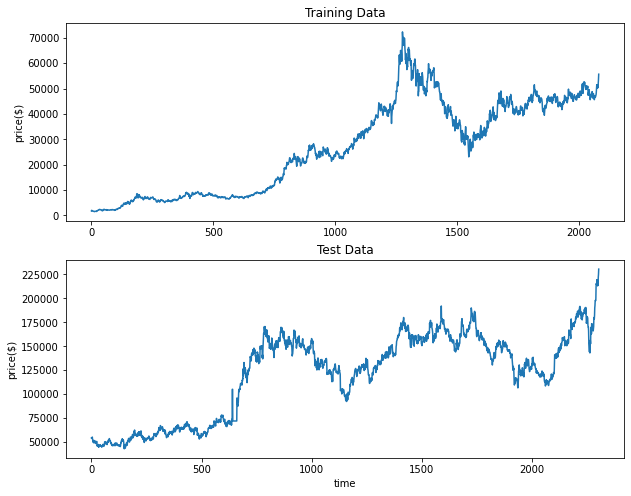

In [ ]:
plt.rcParams["figure.figsize"] = (10,8)
plt.subplot(2, 1, 1)
plt.plot(training_set)
plt.title("Training Data")
plt.ylabel('price($)')

plt.subplot(2, 1, 2)
plt.plot(test_set)
plt.title("Test Data")
plt.xlabel('time')
plt.ylabel('price($)')

학습을 위하여 데이터를 0에서 1 사이의 값으로 scaling 해주도록 하겠습니다. 아래 코드를 실행하면 y축 값이 0에서 1 사이의 값으로 바뀌었음을 확인할 수 있습니다.

Text(0, 0.5, 'scaled price($)')

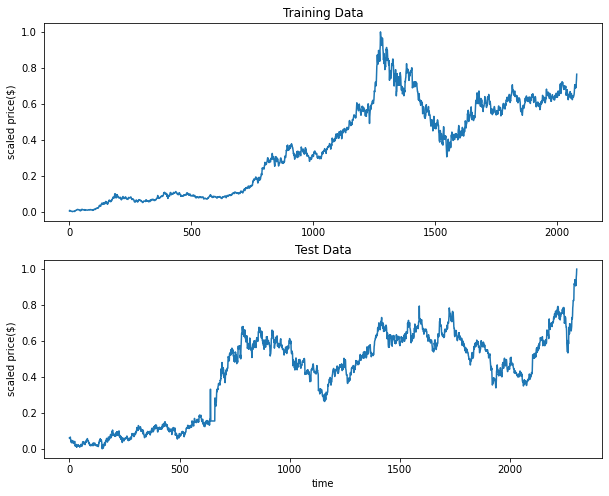

In [ ]:
sc1 = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc1.fit_transform(training_set)
sc2 = MinMaxScaler(feature_range=(0,1))
test_set_scaled = sc2.fit_transform(test_set)

plt.rcParams["figure.figsize"] = (10,8)
plt.subplot(2, 1, 1)
plt.plot(training_set_scaled)
plt.title("Training Data")
plt.ylabel('scaled price($)')

plt.subplot(2, 1, 2)
plt.plot(test_set_scaled)
plt.title("Test Data")
plt.xlabel('time')
plt.ylabel('scaled price($)')

이제 학습을 위해 데이터를 일정한 길이의 sequence로 나누도록 하겠습니다. 아래 코드를 통해 길이가 60인 sequence들로 이루어진 X와 그때의 데이터값 Y로 X_train, Y_train, X_test, Y_test 만들 수 있습니다.

In [ ]:
X_train = []
Y_train = []
for i in range(60, training_set_scaled.shape[0]):
    X_train.append(training_set_scaled[i-60:i, 0])
    Y_train.append(training_set_scaled[i, 0])
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

X_test = []
Y_test = []
for i in range(60, test_set_scaled.shape[0]):
    X_test.append(test_set_scaled[i-60:i, 0])
    Y_test.append(test_set_scaled[i, 0])
X_test, Y_test = np.array(X_test), np.array(Y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# 2. Simple RNN

이제 RNN 모델을 만들기 위해서 LSTM을 사용하겠습니다. LSTM 한개의 층을 이용해 간단한 모델을 생성해 보겠습니다. 

LSTM은 인자로 

units = (output의 shape을 결정)

Input_shape = (input의 형태를 결정)

return_sequences = (output의 형태를 최종출력과 시퀸스 중 선택)

 아래와 같이 레이어를 구성해 보세요.

| Layer (type) | Output Shape | Param # |
|------|------|------|
| LSTM | (None, 5) | 480 |
| Dense | (None, 1) | 11 |

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

model_LSTM = Sequential()

model_LSTM.add(LSTM(5, input_shape = (60,1), return_sequences=False))
model_LSTM.add(Dense(1))

model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5)                 140       
_________________________________________________________________
dense (Dense)                (None, 1)                 6         
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


아래와 같은 조건은로 학습을 시작합니다.

In [ ]:
model_LSTM.compile(optimizer = 'adam', loss = 'mean_squared_error')
model_LSTM.fit(X_train, Y_train, epochs = 10, batch_size = 128)

Epoch 1/10
16/16 [==============================] - 2s 23ms/step - loss: 0.3168
Epoch 2/10
16/16 [==============================] - 0s 23ms/step - loss: 0.2286
Epoch 3/10
16/16 [==============================] - 0s 22ms/step - loss: 0.1451
Epoch 4/10
16/16 [==============================] - 0s 22ms/step - loss: 0.0856
Epoch 5/10
16/16 [==============================] - 0s 24ms/step - loss: 0.0549
Epoch 6/10
16/16 [==============================] - 0s 22ms/step - loss: 0.0373
Epoch 7/10
16/16 [==============================] - 0s 23ms/step - loss: 0.0277
Epoch 8/10
16/16 [==============================] - 0s 23ms/step - loss: 0.0175
Epoch 9/10
16/16 [==============================] - 0s 22ms/step - loss: 0.0103
Epoch 10/10
16/16 [==============================] - 0s 22ms/step - loss: 0.0044


In [ ]:
predicted_X_train = model_LSTM.predict(X_train)
predicted_X_train = sc1.inverse_transform(predicted_X_train)

predcited_X_test = model_LSTM.predict(X_test)
predcited_X_test = sc2.inverse_transform(predcited_X_test)

mean_train_error = np.average(np.abs(training_set[59:-1,:] - predicted_X_train))
mean_test_error = np.average(np.abs(test_set[59:-1,:] - predcited_X_test))


print("평균 training error:", mean_train_error)
print("평균 test error:",mean_test_error)

평균 training error: 2456.66787602003
평균 test error: 7005.729915437082


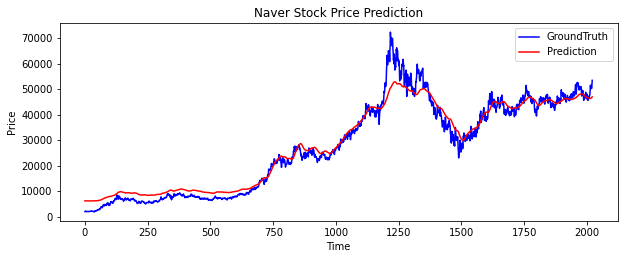

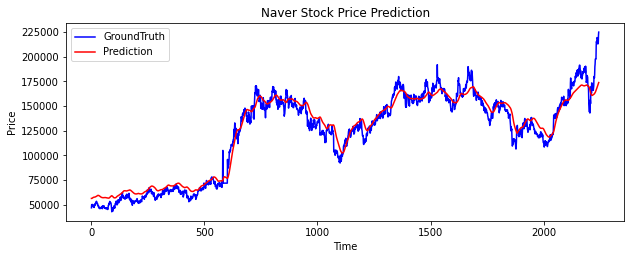

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(training_set[59:-1,:], color = 'blue', label = 'GroundTruth')
plt.plot(predicted_X_train, color = 'red', label = 'Prediction')
plt.title('Naver Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

plt.subplot(2, 1, 2)
plt.plot(test_set[59:-1,:], color = 'blue', label = 'GroundTruth')
plt.plot(predcited_X_test, color = 'red', label = 'Prediction')
plt.title('Naver Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

수행 결과 예측은 성공했으나 실제 그래프인 파란색 선을 제대로 따라가지 못하는 것을 확인했습니다.

# 3. RNN model

이제 더 깊은 RNN 모델을 만들어보도록 하겠습니다. 아래 모델과 같이 레이어를 구성해 보세요.

| Layer (type) | Output Shape | Param # |
|------|------|------|
| LSTM | (None, 60, 50) | 10400 |
| Dropout | (None, 60, 50) | 0 |
| LSTM | (None, 60, 50) | 20200 |
| Dropout | (None, 60, 50) | 0 |
| LSTM | (None, 60, 50) | 20200 |
| Dropout | (None, 60, 50) | 0 |
| LSTM | (None, 50) | 20200 |
| Dropout | (None, 50) | 0 |
| Dense | (None, 1) | 51 |


In [ ]:

model = Sequential()
### START CODE HERE ###
model.add(LSTM(50, input_shape = (60,1), return_sequences=True)) # timestamp,feature
model.add(Dropout(0.3))
model.add(LSTM(50, input_shape = (60,50), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(50, input_shape = (60,50), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(50, input_shape = (60,50), return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1))
### END CODE HERE ###

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 60, 50)            10400     
_________________________________________________________________
dropout_14 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 60, 50)            20200     
_________________________________________________________________
dropout_15 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 60, 50)            20200     
_________________________________________________________________
dropout_16 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 50)               

학습을 시작합니다.

In [ ]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, Y_train, epochs = 10, batch_size = 128)

Epoch 1/10
16/16 [==============================] - 10s 223ms/step - loss: 0.0794
Epoch 2/10
16/16 [==============================] - 4s 218ms/step - loss: 0.0101
Epoch 3/10
16/16 [==============================] - 4s 218ms/step - loss: 0.0055
Epoch 4/10
16/16 [==============================] - 3s 217ms/step - loss: 0.0049
Epoch 5/10
16/16 [==============================] - 4s 218ms/step - loss: 0.0051
Epoch 6/10
16/16 [==============================] - 4s 219ms/step - loss: 0.0042
Epoch 7/10
16/16 [==============================] - 3s 216ms/step - loss: 0.0040
Epoch 8/10
16/16 [==============================] - 3s 215ms/step - loss: 0.0041
Epoch 9/10
16/16 [==============================] - 4s 219ms/step - loss: 0.0040
Epoch 10/10
16/16 [==============================] - 4s 221ms/step - loss: 0.0039


이제 training data의 prediction 결과와 test data의 prediction 결과를 살펴보겠습니다.

In [ ]:
predicted_X_train = model.predict(X_train)
predicted_X_train = sc1.inverse_transform(predicted_X_train)

predcited_X_test = model.predict(X_test)
predcited_X_test = sc2.inverse_transform(predcited_X_test)

mean_train_error = np.average(np.abs(training_set[59:-1,:] - predicted_X_train))
mean_test_error = np.average(np.abs(test_set[59:-1,:] - predcited_X_test))


print("평균 training error:", mean_train_error)
print("평균 test error:",mean_test_error)

평균 training error: 1599.3910603961888
평균 test error: 5983.386553452116


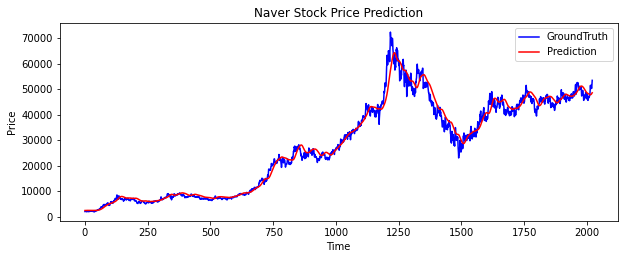

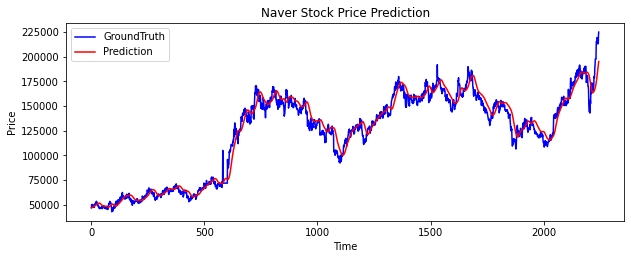

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(training_set[59:-1,:], color = 'blue', label = 'GroundTruth')
plt.plot(predicted_X_train, color = 'red', label = 'Prediction')
plt.title('Naver Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

plt.subplot(2, 1, 2)
plt.plot(test_set[59:-1,:], color = 'blue', label = 'GroundTruth')
plt.plot(predcited_X_test, color = 'red', label = 'Prediction')
plt.title('Naver Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

수행결과 첫번째 모델보다 더 좋은 성능을 보이는 것을 확인했습니다.

# 4. Model save, Load
완성된 모델을 저장하고 불러와서 결과를 확인하는 방법을 보겠습니다. 사용되는 명령어는 save, load_model입니다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
! pwd

Mounted at /content/drive
/content


In [ ]:
import tensorflow as tf
from keras.models import save_model, load_model

model.save('drive/MyDrive/Recent_model.h5')

In [ ]:
recent_model = load_model('drive/MyDrive/Recent_model.h5')

predicted_X_train = recent_model.predict(X_train)
predicted_X_train = sc1.inverse_transform(predicted_X_train)

predcited_X_test = recent_model.predict(X_test)
predcited_X_test = sc2.inverse_transform(predcited_X_test)

mean_train_error = np.average(np.abs(training_set[59:-1,:] - predicted_X_train))
mean_test_error = np.average(np.abs(test_set[59:-1,:] - predcited_X_test))


print("평균 training error:", mean_train_error)
print("평균 test error:",mean_test_error)

평균 training error: 1599.3910603961888
평균 test error: 5983.386553452116


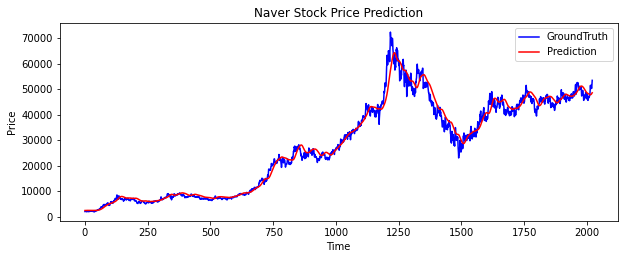

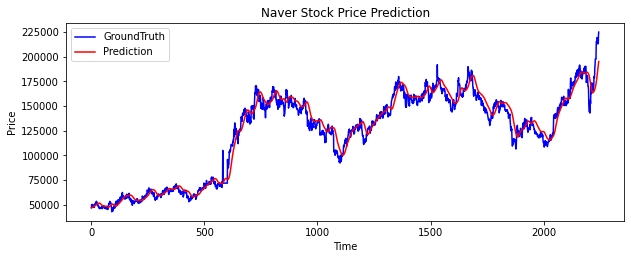

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(training_set[59:-1,:], color = 'blue', label = 'GroundTruth')
plt.plot(predicted_X_train, color = 'red', label = 'Prediction')
plt.title('Naver Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

plt.subplot(2, 1, 2)
plt.plot(test_set[59:-1,:], color = 'blue', label = 'GroundTruth')
plt.plot(predcited_X_test, color = 'red', label = 'Prediction')
plt.title('Naver Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

기존 모델인 model과 불러온 모델 recent_model이 동일한 것을 확인할 수 있었습니다.

# 5. Test Problem

Problem: 이번에는 종목을 바꿔서 KOSPI(종목코드 ^KS11) 주식 2000년 1월 1일부터 2010년 12월 31일까지 주가를 학습데이터로 활용하고 2011년 1월 1일부터 2020년 5월 22일까지 주가를 테스트데이터로 활용해서 주가를 예측해 보세요. 이번 과제는 얼마나 잘 예측하는지 랭킹을 매겨서 공개할 예정입니다. 여러분만의 획기적인 주가 예측 모델을 기대해 봅니다.

여러분들의 모델을 평가하기 위해서 생성한 모델을 "이름_학번.h5"로 저장해주세요. 과제를 제출하실 때는 현재 코드를 작성한 "이름_학번.ipynb" , 보고서, "이름_학번.h5"를 압축해서 "이름_학번.zip"로 업로드 해주시길 바랍니다.

파일의 용량이 너무 큰 경우 hcw511@naver.com으로 보내주시면 됩니다.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as dr
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

### START CODE HERE ###
df_train = dr.DataReader('^KS11', 'yahoo', datetime(2000,1,1), datetime(2010,12,31))
df_test = dr.DataReader('^KS11', 'yahoo', datetime(2011,1,1), datetime(2020,5,22))
### END CODE HERE ###

training_set = df_train.iloc[:, 3:4].values
test_set = df_test.iloc[:, 3:4].values


Data Visualization

Text(0, 0.5, 'price($)')

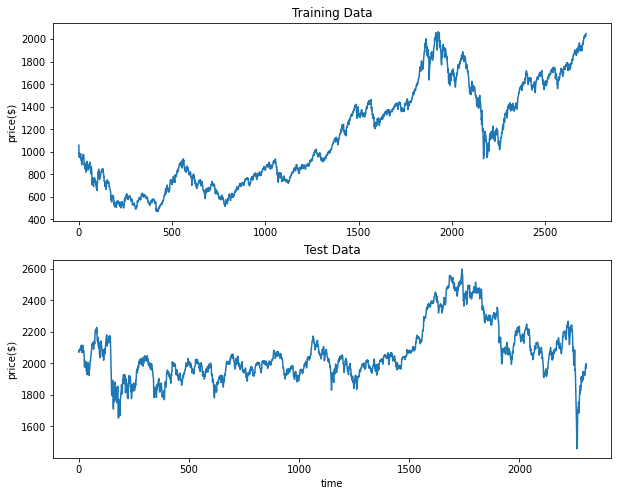

In [8]:
plt.rcParams["figure.figsize"] = (10,8)
plt.subplot(2, 1, 1)
plt.plot(training_set)
plt.title("Training Data")
plt.ylabel('price($)')

plt.subplot(2, 1, 2)
plt.plot(test_set)
plt.title("Test Data")
plt.xlabel('time')
plt.ylabel('price($)')

학습을 위한 Rescaling

Text(0, 0.5, 'scaled price($)')

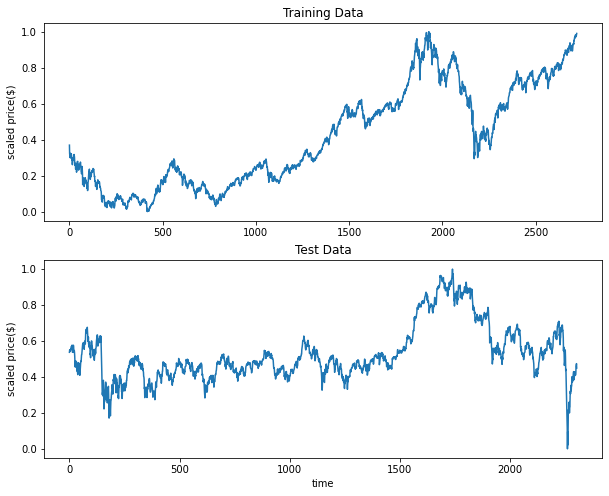

In [9]:
sc1 = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc1.fit_transform(training_set)
sc2 = MinMaxScaler(feature_range=(0,1))
test_set_scaled = sc2.fit_transform(test_set)

plt.rcParams["figure.figsize"] = (10,8)
plt.subplot(2, 1, 1)
plt.plot(training_set_scaled)
plt.title("Training Data")
plt.ylabel('scaled price($)')

plt.subplot(2, 1, 2)
plt.plot(test_set_scaled)
plt.title("Test Data")
plt.xlabel('time')
plt.ylabel('scaled price($)')

In [10]:
X_train = []
Y_train = []
sequence_length = 60
for i in range(sequence_length, training_set_scaled.shape[0]):
    X_train.append(training_set_scaled[i-sequence_length:i, 0])
    Y_train.append(training_set_scaled[i, 0])
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

X_test = []
Y_test = []
for i in range(sequence_length, test_set_scaled.shape[0]):
    X_test.append(test_set_scaled[i-sequence_length:i, 0])
    Y_test.append(test_set_scaled[i, 0])
X_test, Y_test = np.array(X_test), np.array(Y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
pip install tensorflow-addons


     |████████████████████████████████| 686kB 6.8MB/s 


In [ ]:
# 랜덤 시드 고정
import numpy as np
import tensorflow as tf
import random as rd

seed_num = 42
np.random.seed(seed_num)
tf.random.set_seed(seed_num)
rd.seed(seed_num)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM , GRU,  Bidirectional
from keras.layers import Dropout
from keras.layers import LayerNormalization
from keras.layers import TimeDistributed
from keras.layers import Embedding
from keras import initializers

model_test = Sequential()
### START CODE HERE ###
#model_test.add(Dense(100,activation='relu',input_shape=(sequence_length,1)))
model_test.add(GRU(20, input_shape = (sequence_length,1),   activation = 'relu', recurrent_dropout = 0.1, return_sequences=True)) # timestamp,feature
model_test.add(GRU(20, input_shape = (sequence_length,20), activation = 'relu', recurrent_dropout = 0.1, return_sequences=True))
#model_test.add(GRU(35, input_shape = (sequence_length,35), activation = 'relu',  recurrent_dropout = 0.1, return_sequences=True))
model_test.add(GRU(20, input_shape = (sequence_length,20), activation = 'relu', recurrent_dropout = 0.05, return_sequences=False))
model_test.add(Dense(1))
### END CODE HERE ###

model_test.summary() 

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_36 (GRU)                 (None, 60, 20)            1380      
_________________________________________________________________
gru_37 (GRU)                 (None, 60, 20)            2520      
_________________________________________________________________
gru_38 (GRU)                 (None, 20)                2520      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 21        
Total params: 6,441
Trainable params: 6,441
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras import optimizers

optimizer = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.00)

# Learning rate scheduler 선언
learning_rate = 0.001

lr_decay_cb = tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: learning_rate + 0.02 * (0.5 ** (1 + epoch)),
        verbose=False)

callback = [lr_decay_cb]

In [ ]:
model_test.compile(optimizer = 'adam', loss = 'mean_squared_error')
model_test.fit(X_train, Y_train, epochs = 100, batch_size = 64, callbacks=callback)

Epoch 1/100
42/42 [==============================] - 22s 405ms/step - loss: 0.0650
Epoch 2/100
42/42 [==============================] - 17s 392ms/step - loss: 8.0958e-04
Epoch 3/100
42/42 [==============================] - 17s 400ms/step - loss: 3.9890e-04
Epoch 4/100
42/42 [==============================] - 17s 397ms/step - loss: 4.3431e-04
Epoch 5/100
42/42 [==============================] - 17s 399ms/step - loss: 3.3453e-04
Epoch 6/100
42/42 [==============================] - 17s 403ms/step - loss: 3.3184e-04
Epoch 7/100
42/42 [==============================] - 17s 402ms/step - loss: 3.4314e-04
Epoch 8/100
42/42 [==============================] - 17s 397ms/step - loss: 3.3240e-04
Epoch 9/100
42/42 [==============================] - 17s 405ms/step - loss: 3.4344e-04
Epoch 10/100
42/42 [==============================] - 17s 409ms/step - loss: 3.1402e-04
Epoch 11/100
42/42 [==============================] - 17s 396ms/step - loss: 3.0553e-04
Epoch 12/100
42/42 [=========================

In [ ]:
kernal = sequence_length- 1

predicted_X_train = model_test.predict(X_train)
predicted_X_train = sc1.inverse_transform(predicted_X_train)

predcited_X_test = model_test.predict(X_test)
predcited_X_test = sc2.inverse_transform(predcited_X_test)

mean_train_error = np.average(np.abs(training_set[kernal:-1,:] - predicted_X_train))
mean_test_error = np.average(np.abs(test_set[kernal:-1,:] - predcited_X_test))

print("평균 training error:", mean_train_error)
print("평균 test error:",mean_test_error)

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(training_set[kernal:-1,:], color = 'blue', label = 'GroundTruth')
plt.plot(predicted_X_train, color = 'red', label = 'Prediction')
plt.title('KOSPI Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

plt.subplot(2, 1, 2)
plt.plot(test_set[kernal:-1,:], color = 'blue', label = 'GroundTruth')
plt.plot(predcited_X_test, color = 'red', label = 'Prediction')
plt.title('KOSPI Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

Tips :  https://danijar.com/tips-for-training-recurrent-neural-networks/  
timedistributed  
embedding  
Dense layer first  

|모델|특징|Training Loss and result|Test result|
|:---:|:---:|:---:|:---:|  
|GRU+ recurrent_dropout(0.1) 4번, Dense 1번 | sequence length 10, epoch 100, mean squared error, batch size 64 GRU feature 100개,   activation = relu, use bias False   | loss: 2.3724e-04, 평균 training error: 7.966717119544074| 평균 test error: 6.404113130976869 |
|GRU+ recurrent_dropout(0.1) 4번, Dense 1번 | sequence length 10, epoch 100, mean squared error, batch size 64 GRU feature 100개,   activation = relu, use bias False, recurrent_activation = 'tanh'   | loss: 1.5277e-04, 평균 training error: 11.018895649109675| 평균 test error: 9.799408624145189 |
|GRU+ recurrent_dropout(0.1) 4번, Dense 1번 | sequence length 10, epoch 100, mean squared error, batch size 64 GRU feature 100개,   activation = relu, use bias False, unroll : True   | -- , 평균 training error: 9.01797156648766| 평균 test error: 7.312124902514031 |
|GRU+ recurrent_dropout(0.1) 1번, Bidirectional(GRU) 2번 + Dense 1번 | sequence length 10, epoch 100, mean squared error, batch size 64 GRU feature 100개,   activation = relu, use bias False| loss: 2.2019e-04 , 평균 training error: 15.86368122051581| 평균 test error: 14.250108554244768 |
|GRU+ recurrent_dropout(0.1) 1번, Bidirectional(GRU) 2번 + Dense 1번 | sequence length 5, epoch 100, mean squared error, batch size 64 GRU feature 100개,   activation = relu, use bias False| loss: .2019e-04 , 평균 training error: 14.04762246717585| 평균 test error: 14.118371035130764 |
|GRU+ recurrent_dropout(0.1) 1번, Bidirectional(GRU) 1번 + Dense 1번 | sequence length 5, epoch 100, mean squared error, batch size 64 GRU feature 100개,   activation = relu, use bias False| loss: 2.0487e-04 , 평균 training error: 11.402497249703178| 평균 test error: 9.097046803056207 |
|GRU+ recurrent_dropout(0.1) 4번 + Dense 1번 | sequence length 10, epoch 100, mean squared error, batch size 64 GRU feature 100개,   activation = relu, use bias False, RMSprop| loss: 6.0775e-04 , 평균 training error: 17.319505872343| 평균 test error: 15.826270531651863 |
|GRU+LayerNormalization +  recurrent_dropout(0.1) 4번 + Dense 1번 | sequence length 10, epoch 100, mean squared error, batch size 64 GRU feature 100개,   activation = relu, use bias False, RMSprop| loss: 5.4075e-04 , 평균 training error: 14.563348706117726| 평균 test error: 2.584810960739054 |


최종 제출 List  

|모델|특징|Training Loss and result|Test result|  
|:---:|:---:|:---:|:---:|  
|GRU+ recurrent_dropout(0.1) 4번 + Dense 1번 | sequence length 10, epoch 150, mean squared error, batch size 64 GRU feature 40개, activation = relu, adam| loss: 1.5364e-04 , 평균 training error: 5.13371061821801| 평균 test error: 1.3xx |
|GRU+ recurrent_dropout(0.1) 4번 + Dense 1번 (recurrent_dropout = 0.1,   recurrent_dropout = 0.2, recurrent_dropout = 0.1, recurrent_dropout = 0.05) | sequence length 10, epoch 150, mean squared error, batch size 64 GRU feature 40개, activation = relu, adam| loss: 1.4818e-04 , 평균 training error: 1.7748648992206584| 평균 test error: 1.3077090122270498 | - best   
|GRU+ recurrent_dropout(0.1) 4번 + Dense 1번 (recurrent_dropout = 0.05,   recurrent_dropout = 0.1, recurrent_dropout = 0.05, recurrent_dropout = 0.05) | sequence length 10, epoch 150, mean squared error, batch size 64 GRU feature 40개, activation = relu, adam| loss: 1.4671e-04 , 평균 training error: 2.9814270891134385| 평균 test error: 1.9167255802800525 | 
|GRU+ recurrent_dropout(0.1) 4번 + Dense 1번 (recurrent_dropout = 0.1,   recurrent_dropout = 0.2, recurrent_dropout = 0.1, recurrent_dropout = 0.05) | sequence length 10, epoch 150, mean squared error, batch size 64 GRU feature 35개, activation = relu, adam| loss: 1.4682e-04, 평균 training error: 3.5819307059911982 | 3.1465926824831496 |
|GRU+ recurrent_dropout(0.1) 3번 + Dense 1번 (recurrent_dropout = 0.1,   recurrent_dropout = 0.1, recurrent_dropout = 0.05) | sequence length 60, epoch 100, mean squared error, batch size 64 GRU feature 30개, activation = relu, adam| loss: 1.4682e-04, 평균 training error: 3.5819307059911982 | 평균 test error: 3.1465926824831496 |


모델 저장하기

In [5]:
from google.colab import drive
drive.mount('/content/drive')
! pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content


In [2]:
import tensorflow as tf
from keras.models import save_model, load_model

model_test.save('drive/MyDrive/TaeyoungKim_2016741023.h5')

NameError: ignored

In [11]:
from keras.models import load_model
recent_model = load_model('drive/MyDrive/TaeyoungKim_2016741023.h5')

sequence_length = 60
kernal = sequence_length-1

predicted_X_train = recent_model.predict(X_train)
predicted_X_train = sc1.inverse_transform(predicted_X_train)

predcited_X_test = recent_model.predict(X_test)
predcited_X_test = sc2.inverse_transform(predcited_X_test)

mean_train_error = np.average(np.abs(training_set[kernal:-1,:] - predicted_X_train))
mean_test_error = np.average(np.abs(test_set[kernal:-1,:] - predcited_X_test))


print("평균 training error:", mean_train_error)
print("평균 test error:",mean_test_error)

평균 training error: 1.77486702088618
평균 test error: 1.307711895349404


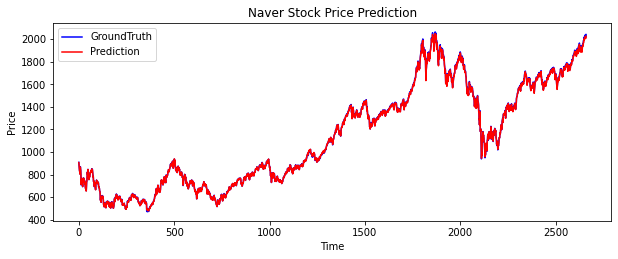

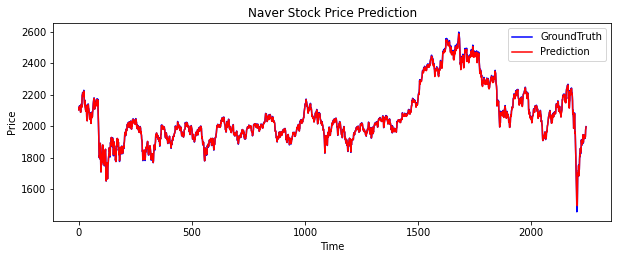

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(training_set[kernal:-1,:], color = 'blue', label = 'GroundTruth')
plt.plot(predicted_X_train, color = 'red', label = 'Prediction')
plt.title('Naver Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

plt.subplot(2, 1, 2)
plt.plot(test_set[kernal:-1,:], color = 'blue', label = 'GroundTruth')
plt.plot(predcited_X_test, color = 'red', label = 'Prediction')
plt.title('Naver Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()